# Classifying Usages of Cars

In this project, I implemented the DecisionTreeClassifier from scatch to predict usages of cars (commercial or private) based on categorical predictors only. The rationale behind this implementation is that encoding categorical features into dummy variables would lead to a poorer result, but it is the best practice so far.

In [44]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
# Load data set
cars = pd.read_csv('claim_history.csv')
cars.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE', 'URBANICITY', 'CLM_COUNT',
       'EXPOSURE'],
      dtype='object')

In [23]:
# Extract predictive features, CAR_USE is the target variable
cars = cars[['CAR_USE', 'CAR_TYPE', 'OCCUPATION', 'EDUCATION']]
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 4 columns):
CAR_USE       10302 non-null object
CAR_TYPE      10302 non-null object
OCCUPATION    10302 non-null object
EDUCATION     10302 non-null object
dtypes: object(4)
memory usage: 322.1+ KB


In [24]:
# Split the data into train/test set
X_train, X_test = train_test_split(cars, test_size=0.3, random_state=1, stratify=cars['CAR_USE'])

In [25]:
X_train.head()

,CAR_USE,CAR_TYPE,OCCUPATION,EDUCATION
1153,Private,Sports Car,Lawyer,Masters
5256,Private,SUV,Blue Collar,High School
3354,Commercial,Panel Truck,Unknown,Masters
2561,Private,Sports Car,Home Maker,Bachelors
400,Private,SUV,Professional,Bachelors


In [26]:
# A function that calculates the entropy of a split in a variable
def entropy_split(df, predictor):
    categories = df[predictor].unique().tolist()
    cross_table = pd.crosstab(df[predictor], df['CAR_USE'], margins=True)
    print(cross_table)
    print()
    root_entropy = -(cross_table.loc['All', 'Commercial'] / cross_table.loc['All', 'All'] *\
                     np.log2(cross_table.loc['All', 'Commercial'] / cross_table.loc['All', 'All']) +\
                     cross_table.loc['All', 'Private'] / cross_table.loc['All', 'All'] *\
                     np.log2(cross_table.loc['All', 'Private'] / cross_table.loc['All', 'All']))
    
    entropies = []
    for j in range(1, len(categories)-1):
        coms = list(combinations(categories, j)) # Iterate all possible number of subsets
        for category in coms:
            ent1 = 0
            prob = 0
            category_all = 0
            category_commercial = 0
            category_private = 0
            tot_entropy = 0
            all_all = cross_table.loc['All', 'All']
            for i in range(len(category)):
                category_all += cross_table.loc[category[i], 'All']
                category_commercial += cross_table.loc[category[i], 'Commercial']
                category_private += cross_table.loc[category[i], 'Private']
            prob = category_commercial / category_all
            if prob > 0:
                ent1 -= prob * np.log2(prob)
            prob = category_private / category_all # Weighted probability of the subset
            if prob > 0:
                ent1 -= prob * np.log2(prob)
            weight_1 = category_all / all_all
            #ent1 = prob * ent1
            
            ent2 = 0
            prob = 0
            prob = (cross_table.loc['All', 'Commercial'] - category_commercial) / (all_all - category_all)
            if prob > 0:
                ent2 -= prob * np.log2(prob)
            prob = (cross_table.loc['All', 'Private'] - category_private) / (all_all - category_all)
            if prob > 0:
                ent2 -= prob * np.log2(prob)
            weight_2 = (all_all - category_all) / all_all # Weighted probability of the subset
            #ent2 = prob * ent2
            
            tot_entropy = weight_1 * ent1 + weight_2 * ent2
            category_2 = []
            for cat in categories:
                if cat not in category:
                    category_2.append(cat)
            category_2 = tuple(category_2)
            entry = [(category, ent1), (category_2, ent2), ('Split entropy =', tot_entropy)]
            entropies.append(entry)
    
    return root_entropy, entropies

# A function display the entropy information of a split in a variable
def predictor_split(df, node):
    print('\nFind the best predictor to split on ' + node + ':\n')
    entropies = {}
    best_set = []
    largest = 0
    for predictor in df.columns[1:]: # 'CAR_TYPE', 'OCCUPATION', 'EDUCATION'
        root_entropy, entropies[predictor] = entropy_split(df, predictor)
        entropies[predictor].sort(key=lambda x: float(x[2][1])) # Sort by the lowest entropy
        print('Entropy of the root node =', root_entropy)
        print('The split criterion on predictor: ' + predictor)
        best_subset_1 = entropies[predictor][0][0][0]
        best_subset_2 = entropies[predictor][0][1][0]
        print(best_subset_1, 'entropy =', entropies[predictor][0][0][1])
        print(best_subset_2, 'entropy =', entropies[predictor][0][1][1])
        print('Split entropy =', entropies[predictor][0][2][1])
        split_entropy = entropies[predictor][0][2][1]
        largest_reduction = root_entropy - split_entropy
        print('Reduction =', root_entropy, '-', split_entropy, '=', largest_reduction)  
        print('\n')
        
        if largest_reduction > largest:
            largest = largest_reduction
            best_set = [best_subset_1, best_subset_2]
        
    print("Since the split " + str(best_set) + " gives the largest reduction in entropy " + str(largest) +\
          ", the child nodes of " + node + " are " + str(best_set) + "\n\n")

In [31]:
# Find the best feature to split in the root node and its best cutpoint
predictor_split(X_train, 'root')


Find the best predictor to split on root:

CAR_USE      Commercial  Private   All
CAR_TYPE                              
Minivan             393     1498  1891
Panel Truck         597        0   597
Pickup              751      507  1258
SUV                 403     1618  2021
Sports Car          133      684   817
Van                 375      252   627
All                2652     4559  7211

Entropy of the root node = 0.9489455789827704
The split criterion on predictor: CAR_TYPE
('Sports Car', 'SUV', 'Minivan') entropy = 0.7147658445633102
('Panel Truck', 'Pickup', 'Van') entropy = 0.8882677391690654
Split entropy = 0.774484566295592
Reduction = 0.9489455789827704 - 0.774484566295592 = 0.1744610126871784


CAR_USE       Commercial  Private   All
OCCUPATION                             
Blue Collar         1226      383  1609
Clerical             190      936  1126
Doctor                 0      230   230
Home Maker            33      539   572
Lawyer                 0      723   723
Man

In [32]:
# Split the root node into two child nodes based on the above criterion
cars_train_left = cars[cars['OCCUPATION'].isin(['Blue Collar', 'Unknown', 'Student'])]
cars_train_right = cars[cars['OCCUPATION'].isin\
                        (['Professional', 'Manager', 'Clerical', 'Doctor', 'Lawyer', 'Home Maker'])]

In [28]:
# entropy calculation
def entropy(df, predictor):
    cross_table = pd.crosstab(df[predictor], df['CAR_USE'], margins=True)
    print()
    print(cross_table)
    node_entropy = -(cross_table.loc['All', 'Commercial'] / cross_table.loc['All', 'All'] *\
                     np.log2(cross_table.loc['All', 'Commercial'] / cross_table.loc['All', 'All']) +\
                     cross_table.loc['All', 'Private'] / cross_table.loc['All', 'All'] *\
                     np.log2(cross_table.loc['All', 'Private'] / cross_table.loc['All', 'All']))
    return node_entropy

# A fucntion that displays the class of CAR_USE based on the predicted probability
def predict_class(n_private, n_commercial):
    if n_private > n_commercial:
        print('Predicted class = ' + 'Private')
    else:
        print('Predicted class = ' + 'Commercial')

# A function that displays the information of a terminal node
def describe_leaf(leaf_name, df):
    leaf_entropy = entropy(df, 'CAR_TYPE')
    print()
    print(leaf_name)
    print('Entropy =', leaf_entropy)
    print('samples =', df.shape[0])
    size = df.groupby('CAR_USE').size()
    n_commercial = size[0]
    n_private = size[1]
    print('values = [' + str(n_private) + ', ' + str(n_commercial) + ']')
    print('Probability of Commercial:', n_commercial/(n_private + n_commercial))
    predict_class(n_private, n_commercial)

In [33]:
# Split the left node into two leaves
cars_leaf_below_high_school = cars_train_left[cars_train_left['EDUCATION'].isin(['Below High School'])]
cars_leaf_name = "Leaf node ({'Blue Collar', 'Unknown', 'Student'} & {'Below High School'}):"
describe_leaf(cars_leaf_name, cars_leaf_below_high_school)  

cars_leaf_high_school_and_above = cars_train_left[cars_train_left['EDUCATION'].isin(['High School', 'Bachelors', 'Masters', 'Doctors'])]
cars_leaf_name = "Leaf node ({'Blue Collar', 'Unknown', 'Student'} & {'High School', 'Bachelors', 'Doctors', 'Masters'}):"
describe_leaf(cars_leaf_name, cars_leaf_high_school_and_above)  

# Split the right node into two leaves
cars_leaf_minivan_suv_sports_car = cars_train_right[cars_train_right['CAR_TYPE'].isin(['Minivan', 'SUV', 'Sports Car'])]
cars_leaf_name = "Leaf node ({'Manager', 'Doctor', 'Clerical', 'Professional', 'Lawyer', 'Home Maker'} & {'Minivan', 'SUV', 'Sports Car'}):"
describe_leaf(cars_leaf_name, cars_leaf_minivan_suv_sports_car)  

cars_leaf_van_pickup_panel_truck = cars_train_right[cars_train_right['CAR_TYPE'].isin(['Van', 'Pickup', 'Panel Truck'])]
cars_leaf_name = "Leaf node ({'Manager', 'Doctor', 'Clerical', 'Professional', 'Lawyer', 'Home Maker'} & {'Van', 'Pickup', 'Panel Truck'})"
describe_leaf(cars_leaf_name, cars_leaf_van_pickup_panel_truck)  


CAR_USE      Commercial  Private  All
CAR_TYPE                             
Minivan              23      168  191
Panel Truck          36        0   36
Pickup              100       95  195
SUV                  15      230  245
Sports Car            5       90   95
Van                  37       24   61
All                 216      607  823

Leaf node ({'Blue Collar', 'Unknown', 'Student'} & {'Below High School'}):
Entropy = 0.8304276080710689
samples = 823
values = [607, 216]
Probability of Commercial: 0.2624544349939247
Predicted class = Private

CAR_USE      Commercial  Private   All
CAR_TYPE                              
Minivan             520      161   681
Panel Truck         437        0   437
Pickup              569       60   629
SUV                 527      164   691
Sports Car          188       71   259
Van                 318       14   332
All                2559      470  3029

Leaf node ({'Blue Collar', 'Unknown', 'Student'} & {'High School', 'Bachelors', 'Doctors', 'M

In [38]:
# Calculate the metrics on the model on the train data set
pred_probability = np.ndarray(shape=(len(X_train), ), dtype=float)
X_train = X_train.reset_index(drop=True)
for i in range(len(X_train)):
    if X_train.loc[i, 'OCCUPATION'] in ['Blue Collar', 'Unknown', 'Student']: # First split based on occupation
        if X_train.loc[i, 'EDUCATION'] in ['Below High School']: # left node split based on education
            pred_probability[i] = 0.2625
        elif X_train.loc[i, 'EDUCATION'] in ['High School', 'Bachelors', 'Masters', 'Doctors']:
            pred_probability[i] = 0.8448
    elif X_train.loc[i, 'OCCUPATION'] in ['Professional', 'Manager', 'Clerical', 'Doctor', 'Lawyer', 'Home Maker']:
        if X_train.loc[i, 'CAR_TYPE'] in ['Minivan', 'SUV', 'Sports Car']: # right node split based on car type
            pred_probability[i] = 0.0065
        elif X_train.loc[i, 'CAR_TYPE'] in ['Van', 'Pickup', 'Panel Truck']:
            pred_probability[i] = 0.5302

prob_dist_train = X_train.groupby('CAR_USE').size() / X_train.shape[0]
threshold = prob_dist_train[0]

y_test = X_train['CAR_USE']
y_pred = np.empty_like(y_test)
count = 0
for i in range(len(y_test)):
    if pred_probability[i] >= threshold:
        y_pred[i] = 'Commercial'
    elif pred_probability[i] < threshold:
        y_pred[i] = 'Private'
    if y_pred[i] != y_test[i]: # predicted event not qeual to observed target value
        count += 1
missclassification_rate = count / len(y_test)
print("Misclassification Rate =", missclassification_rate)
print()

from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score,  roc_curve, accuracy_score
           
y_true = np.array(y_test.apply(lambda x: 1 if x == 'Commercial' else 0))
y_prob = np.array(pred_probability)
MSE = mean_squared_error(y_true, y_prob)
RMSE = np.sqrt(MSE)   

AUC = roc_auc_score(y_true, y_prob)
print('Area Under the Curve =', AUC)       

a) Misclassification Rate = 0.153099431424213

c) Area Under the Curve = 0.9223458099388708


In [40]:
# Predict the probability of CAR_TYPE = Commercial
pred_probability = np.ndarray(shape=(len(X_test), ), dtype=float)
X_test = X_test.reset_index(drop=True)
for i in range(len(X_test)):
    if X_test.loc[i, 'OCCUPATION'] in ['Blue Collar', 'Unknown', 'Student']: # First split based on occupation
        if X_test.loc[i, 'EDUCATION'] in ['Below High School']: # left node split based on education
            pred_probability[i] = 0.2625
        elif X_test.loc[i, 'EDUCATION'] in ['High School', 'Bachelors', 'Masters', 'Doctors']:
            pred_probability[i] = 0.8448
    elif X_test.loc[i, 'OCCUPATION'] in ['Professional', 'Manager', 'Clerical', 'Doctor', 'Lawyer', 'Home Maker']:
        if X_test.loc[i, 'CAR_TYPE'] in ['Minivan', 'SUV', 'Sports Car']: # right node split based on car type
            pred_probability[i] = 0.0065
        elif X_test.loc[i, 'CAR_TYPE'] in ['Van', 'Pickup', 'Panel Truck']:
            pred_probability[i] = 0.5302

# Calculate the missclasification rate with threshold 0.3677714602690334 for Commerical event in the Test partition
y_test = X_test['CAR_USE']
y_pred = np.empty_like(y_test)
count = 0
for i in range(len(y_test)):
    if pred_probability[i] >= threshold:
        y_pred[i] = 'Commercial'
    elif pred_probability[i] < threshold:
        y_pred[i] = 'Private'
    if y_pred[i] != y_test[i]: # predicted event not qeual to observed target value
        count += 1
missclassification_rate = count / len(y_test)
print("Misclassification Rate =", missclassification_rate)

a) Misclassification Rate = 0.15658362989323843


In [42]:
# Calculate the RASE in the Test partition
ASE = 0
for i in range(len(y_test)):
    if y_test.values[i] == 'Commercial':
        ASE += (1 - pred_probability[i]) ** 2
    else:
        ASE += (0 - pred_probability[i]) ** 2
RASE = np.sqrt(ASE/len(y_test))
print('Root Average Squared Error =', RASE)
print()

# Calculate the Root Mean Squared Error in the Test partition
y_true = np.array(y_test.apply(lambda x: 1 if x == 'Commercial' else 0))
y_prob = np.array(pred_probability)
MSE = mean_squared_error(y_true, y_prob)
RMSE = np.sqrt(MSE)


# Calculate the Area Under Curve in the Test partition
AUC = roc_auc_score(y_true, y_prob)
print('Area Under the Curve =', AUC)

Root Average Squared Error = 0.32473375823381073

Area Under the Curve = 0.9144352652790793


Receiver Operating Characteristic curve:


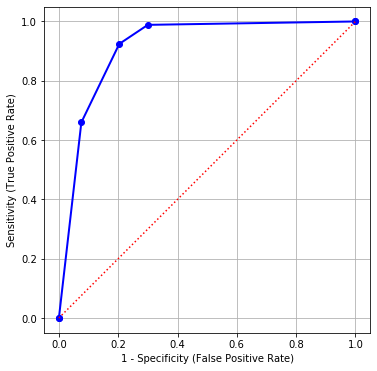

In [46]:
# Generate the coordinates for the ROC curve
OneMinusSpecificity, Sensitivity, thresholds = roc_curve(y_true, y_prob, pos_label = 1)

# Add two dummy coordinates
OneMinusSpecificity = np.append([0], OneMinusSpecificity)
Sensitivity = np.append([0], Sensitivity)

OneMinusSpecificity = np.append(OneMinusSpecificity, [1])
Sensitivity = np.append(Sensitivity, [1])

# Draw the ROC curve
print('Receiver Operating Characteristic curve:')
plt.figure(figsize=(6,6))
plt.plot(OneMinusSpecificity, Sensitivity, marker = 'o',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.plot([0, 1], [0, 1], color = 'red', linestyle = ':')
plt.grid(True)
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
ax = plt.gca()
ax.set_aspect('equal')
plt.show()